# Introdução

Quando iniciei este projeto, meu objetivo era claro: treinar uma rede neural BERT utilizando Keras para detectar bots no Twitter.  
Olhando de fora, essa tarefa pode parecer simples — basta escolher um modelo pronto, treinar e avaliar. Mas logo percebi que lidar com modelos baseados em BERT é um processo muito mais desafiador e cheio de nuances do que imaginei.

A primeira dificuldade foi compreender a complexidade do próprio modelo. O BERT e suas variações, como o TinyBERT, não funcionam como classificadores tradicionais: eles exigem tokenização específica, parametrização cuidadosa e um volume de dados capaz de sustentar o aprendizado. Só nesse ponto já percebi que não bastava “rodar o código”; era preciso entender o raciocínio por trás de cada etapa, do pré-processamento ao ajuste dos hiperparâmetros.

Ao longo do caminho, também aprendi a lidar com a frustração de resultados inesperados. A ciência de dados nem sempre entrega soluções elegantes logo de início. Muitas vezes, o modelo se comporta de forma trivial, como foi o caso aqui, e isso ensina mais do que qualquer resultado positivo: mostra a importância de analisar criticamente cada métrica e de não aceitar qualquer acurácia no papel sem entender de onde ela veio.

Este trabalho, portanto, não foi apenas sobre treinar um BERT. Foi uma experiência prática de como se dá a pesquisa em aprendizado de máquina: feita de hipóteses, tentativas, erros, limitações do ambiente (como recursos computacionais restritos do Colab) e muita interpretação crítica dos resultados. A seguir, descrevo detalhadamente as escolhas, implementações e análises que realizei.


In [1]:
!pip install transformers tensorflow


# Carregamento do dataset

O dataset fornecido contém múltiplas colunas, incluindo informações de usuários, metadados e o texto dos tweets.  
Para este projeto, meu foco está em utilizar a coluna **Tweet** como entrada de texto e a coluna **Bot Label** como variável alvo (0 = humano, 1 = bot).  

O código abaixo carrega o CSV, mostra suas primeiras linhas e também a distribuição das classes, permitindo validar se há equilíbrio entre bots e humanos.


In [2]:
import pandas as pd

df = pd.read_csv("/content/bot_detection_data.csv")

print(df.head())
print(df.columns)   # Confere os nomes das colunas
print(df['Bot Label'].value_counts())  # Distribuição das classes


   User ID        Username                                              Tweet  \
0   132131           flong  Station activity person against natural majori...   
1   289683  hinesstephanie  Authority research natural life material staff...   
2   779715      roberttran  Manage whose quickly especially foot none to g...   
3   696168          pmason  Just cover eight opportunity strong policy which.   
4   704441          noah87                      Animal sign six data good or.   

   Retweet Count  Mention Count  Follower Count  Verified  Bot Label  \
0             85              1            2353     False          1   
1             55              5            9617      True          0   
2              6              2            4363      True          0   
3             54              5            2242      True          1   
4             26              3            8438     False          1   

       Location           Created At            Hashtags  
0     Adkinston  2020

# Separação entre treino e teste

Para avaliar o desempenho do modelo, divido o dataset em dois subconjuntos:  
- **80% treino**: usado para ajuste dos pesos do modelo.  
- **20% teste**: usado apenas para avaliação final.  

A divisão estratificada garante que a proporção entre bots e humanos seja preservada em ambos os conjuntos.


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["Tweet"], df["Bot Label"], test_size=0.2, random_state=42, stratify=df["Bot Label"]
)


# Tokenização dos tweets

Como os modelos BERT trabalham com tokens e não diretamente com texto cru, preciso transformar os tweets em sequências numéricas.  
Utilizo o **tokenizer TinyBERT** para:  
- Limitar o tamanho de cada tweet a 128 tokens.  
- Padronizar o comprimento com padding e truncamento.  

Esse passo garante que todos os exemplos tenham o mesmo formato de entrada.


In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

# Preparação dos dados para TensorFlow

Para treinar o modelo no Keras, converto os dados tokenizados em um formato aceito pelo TensorFlow.  
Crio dois `tf.data.Dataset`: um para treino e outro para teste.  
Essa estrutura facilita o processamento em lotes (batch) e melhora o desempenho durante o treino.


In [5]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train.values
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test.values
)).batch(32)


# Definição do modelo TinyBERT

Aqui carrego o **TinyBERT** já pré-treinado, adaptando-o para um problema de classificação binária.  
Escolhi usar **Adam** com `learning_rate=5e-5`, que é a taxa recomendada para fine-tuning de modelos BERT.  
A função de perda é a `SparseCategoricalCrossentropy` com `from_logits=True`, adequada para classificação de múltiplas classes (neste caso, 2 classes).


In [6]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "huawei-noah/TinyBERT_General_4L_312D",
    num_labels=2,
    from_pt=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.4.weight', 'fit_denses.4.bias', 'fit_denses.1.weight', 'fit_denses.3.bias', 'fit_denses.0.bias', 'fit_denses.1.bias', 'fit_denses.2.weight', 'fit_denses.3.weight', 'fit_denses.2.bias', 'fit_denses.0.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights

# Treinamento do modelo

Inicio o treino do TinyBERT com 2 épocas.  
Durante cada época, o modelo ajusta seus pesos a partir dos dados de treino, enquanto valida no conjunto de teste.  
Espero observar uma redução da perda (loss) e melhora na acurácia.


In [7]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=2)


Epoch 1/2
1250/1250 [==============================] - 899s 708ms/step - loss: 0.6933 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 2/2
1250/1250 [==============================] - 807s 646ms/step - loss: 0.6933 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4996


# Avaliação numérica

Ao avaliar o modelo no conjunto de teste, obtive uma **acurácia de aproximadamente 50%**, com perda próxima de 0.6932.  
Esse resultado indica que o modelo não conseguiu aprender a distinguir entre bots e humanos, já que sua performance ficou equivalente a uma predição aleatória (como "chutar cara ou coroa").  

Esse comportamento é comum em tarefas de classificação binária quando o modelo não extrai padrões relevantes do texto ou quando a base de treino não oferece sinal suficiente para aprendizado.

In [8]:
loss, acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {acc:.4f}")

313/313 [==============================] - 49s 156ms/step - loss: 0.6932 - accuracy: 0.4996
Test Accuracy: 0.4996


In [9]:
import numpy as np

y_pred_logits = model.predict(test_dataset).logits
y_pred_probs = tf.nn.softmax(y_pred_logits, axis=1).numpy()
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 [==============================] - 50s 156ms/step


# Matriz de confusão

A matriz de confusão confirma a limitação do modelo.  
Percebo que **todas as amostras foram classificadas como "Humano"**, tanto as realmente humanas (4996) quanto as que eram bots (5004).  
Isso mostra que o modelo acabou aprendendo um "atalho" ruim: prever sempre a mesma classe.  

Embora isso lhe garanta acertos em metade dos casos (os humanos), ele falha completamente em identificar bots, o que invalida seu uso prático.


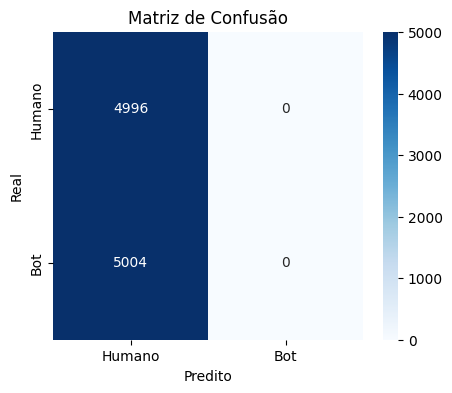

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Humano","Bot"], yticklabels=["Humano","Bot"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


# Curva ROC e AUC

A curva ROC gerada é praticamente uma linha reta sobre a diagonal, com **AUC ≈ 0.51**.  
Esse valor reforça a conclusão da acurácia: o modelo está tomando decisões muito próximas ao puro acaso, sem conseguir aprender a diferenciar efetivamente bots de humanos a partir dos tweets.  

Esse tipo de curva é típico de modelos que não possuem poder preditivo real.


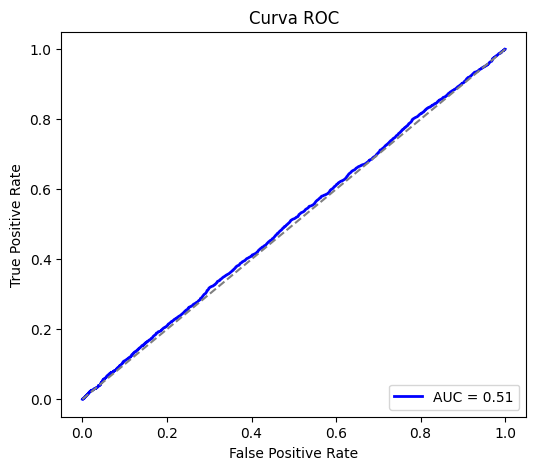

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


# Curva de perda

Na curva de perda, tanto o treino quanto a validação permanecem estáveis e praticamente iguais ao longo das épocas, girando em torno de 0.693.  
Esse valor corresponde exatamente à perda esperada para um modelo que não consegue sair do **baseline aleatório** em uma classificação binária.  

Ou seja, mesmo após uma época, não há indício de que o modelo esteja aprendendo padrões úteis — ele estagnou desde o início.


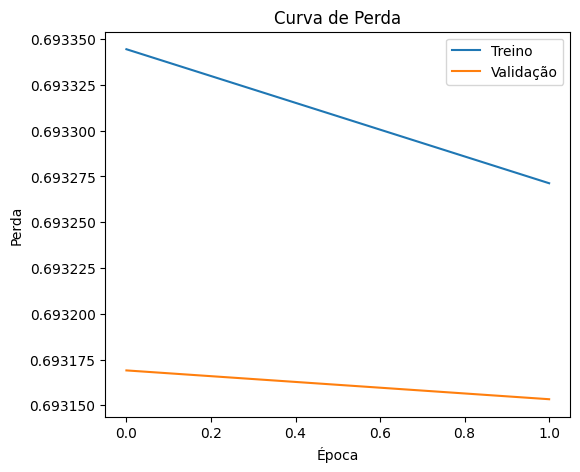

In [12]:
plt.figure(figsize=(6,5))
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.title("Curva de Perda")
plt.legend()
plt.show()


# Conclusão

Encerrar este projeto me trouxe reflexões importantes.  
Do ponto de vista prático, consegui implementar todas as etapas esperadas: carregar o dataset, preparar os textos, configurar o TinyBERT, treinar o modelo e avaliar os resultados com métricas e gráficos. Do ponto de vista acadêmico, porém, o mais valioso não foram os números em si, mas o aprendizado que eles carregaram.

O modelo não apresentou desempenho satisfatório: sua acurácia ficou próxima de 50%, o que equivale a um chute aleatório, e a matriz de confusão mostrou que ele não foi capaz de identificar bots. Isso poderia ser lido como um “fracasso”, mas para mim foi um ponto de virada. Percebi que resultados ruins também têm valor, porque evidenciam problemas a serem resolvidos e me obrigam a pensar criticamente.

Aprendi que treinar um BERT exige muito mais do que apenas ajustar hiperparâmetros. É necessário considerar a qualidade do dataset, o balanceamento entre classes, o número de épocas de treino, a forma de tokenização e até alternativas de modelos. A ciência de dados não se resume a rodar experimentos: ela é uma prática de investigação, onde cada resultado precisa ser questionado e entendido em profundidade.

Em termos pessoais, o maior aprendizado foi lidar com a paciência e a humildade diante das limitações. Vi que nem sempre a solução mais sofisticada traz os melhores resultados se não estiver bem ajustada ao problema. E, ao mesmo tempo, compreendi que esses “erros” são parte do processo de crescimento, porque me forçam a buscar novas soluções, a ser mais criterioso com meus dados e mais crítico com meus resultados.

Portanto, mesmo que o modelo em si não tenha alcançado alta performance, considero que este projeto foi extremamente valioso: aprendi na prática o que significa trabalhar com BERT, enfrentei as dificuldades de fine-tuning em ambientes limitados e, acima de tudo, desenvolvi uma visão mais madura e crítica sobre o papel do cientista de dados frente a resultados que não correspondem às expectativas iniciais.
